# Generating the Final Kaggle Submission



In [1]:
## 1. Mount drive.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model

# Set the randomizer seed so results are reproducable.
np.random.seed(20)
tf.random.set_seed(42)

%matplotlib inline

### Process Data

In [3]:
# Import data from google drive.
og_data_dir = "./drive/MyDrive/w207_facial_detection/Model_14/Kaggle_Data/training.csv"
sup_data_dir = "./drive/MyDrive/w207_facial_detection/Model_14/Semi-Supervised_Model/OG_Semi-Supervised_Model/training_semiSup_filled.csv"
test_dir = "./drive/MyDrive/w207_facial_detection/Model_14/Kaggle_Data//test.csv"

# Input data into pandas dataframe obj. 
og_raw_training_data = pd.read_csv(og_data_dir)
sup_raw_training_data = pd.read_csv(sup_data_dir)
final_test_data = pd.read_csv(test_dir)

In [4]:
## Preprocess Data.

def str_splitter_img(img_str: str):
  """
  Purpose: Takes the string of pixel values for each observation and converts 
  the string into a numpy array of floats. If a pixel value is missing, replaces 
  the missing value with 0.

  Output: img: list of cleaned pixel values.
  """
  img = img_str.split()
  img = ['0' if x == '' else x for x in img]
  return img

def load_images(image_data):
  """
  Purpose: Takes dataframe with Image column and transforms image values into a 
  96x96x1 numpy array of float values between 0 and 1. Please note, the extra 
  dimension is for TF models.

  Output: images: 96x96x1 numpy array of image pixels. 
  """
  images = []
  for idx, sample in image_data.iterrows():
      image = np.array(str_splitter_img(sample['Image']), dtype=int)
      image = np.reshape(image, (96,96,1))
      images.append(image)
  images = np.array(images)/255
  return images

def load_keypoints(df):
  """
  Purpose: Takes a dataframe with keypoints columns and convert them into float 
  numpy array of keypoints.

  Output: keypoint_features: float numpy array of keypoints. Each example is 
  (30,) array of floats. 
  """
  keypoint_features = df.iloc[:,:-1].values
  return keypoint_features

## Build blanket function to control preprocessing functions.
def preprocessor(df, fill=False):
  """
  Purpose: Takes a dataframe of raw data and separates the input (image pixel 
  values) from the output (facial keypoint values). The function also controls 
  all the transformations applied to these segments of data.

  Output: tuple of transformed output (X) and input (Y).
  """

  # 1. Convert training data string of floats into a float numpy array and 
  #    transform each float into a value between 0 and 1.
  X = load_images(df)

  # 2. Convert training labels into a float numpy array.  
  Y = load_keypoints(df)

  return X, Y


In [5]:
def segment_data(data):
  """
  Purpose: Takes full raw data in pandas dataframe and preprocesses data into 
  cleaned input and output numpy arrays.

  Output: Segmented data and labels into test, dev and training splits.
  """
  # Preprocess data.
  X, Y = preprocessor(data)

  # Shuffle data. 
  shuffle = np.random.permutation(np.arange(X.shape[0]))
  X, Y = X[shuffle], Y[shuffle]

  print('data shape: ', X.shape)
  print('label shape:', Y.shape)

  # Set variables to hold test, dev, and training data.
  test_data, test_labels = X[6000:], Y[6000:]
  dev_data, dev_labels = X[5900:6000], Y[5900:6000]
  train_data, train_labels = X[:5900], Y[:5900]
 
  return test_data, test_labels, dev_data, dev_labels, train_data, train_labels

In [6]:
# Split and preprocess original training data.
print("Original Data & Labels:")
og_test_data, og_test_labels, \
og_dev_data, og_dev_labels, \
og_train_data, og_train_labels = segment_data(og_raw_training_data)

# Split and preprocess semi-supervised training data.
print("\nSemi-Supervised Data & Labels:")
sup_test_data, sup_test_labels, \
sup_dev_data, sup_dev_labels, \
sup_train_data, sup_train_labels = segment_data(sup_raw_training_data)

# Preprocess test data.
X_test_final = load_images(final_test_data)

Original Data & Labels:
data shape:  (7049, 96, 96, 1)
label shape: (7049, 30)

Semi-Supervised Data & Labels:
data shape:  (7049, 96, 96, 1)
label shape: (7049, 30)


In [7]:
def remove_nan_obsv(X, Y):
  """
  Purpose: Takes input and output numpy arrays and removes all observations with 
  a NaN in the output data. 

  Output: Input and output numpy arrays with only observations with complete 
  output values.
  """
  # Remove all training examples with an NaN in the output data.
  id_perfect_observations = lambda y: True if (sum(np.isnan(y)) == 0) else False

  perf_data = []
  perf_labels = []
  for x, y in zip(X, Y):
      if id_perfect_observations(y) == True:
          perf_data.append(x)
          perf_labels.append(y)

  perf_data = np.array(perf_data)
  perf_labels = np.array(perf_labels)

  print("perfect data shape:", end =' ')    
  print(perf_data.shape)

  print("perfect labels shape:", end =' ')   
  print(perf_labels.shape)

  nan_count = np.isnan(perf_labels).sum()
  print("There are %.0f NaN values in perfect_labels"%(nan_count))

  return perf_data, perf_labels

In [8]:
# Extract complete observations in the dev and test data.
print("\nFor Original Dev Data:")
perf_dev_data, perf_dev_labels = remove_nan_obsv(og_dev_data, og_dev_labels)

print("\nFor Original Test Data:")
perf_test_data, perf_test_labels = remove_nan_obsv(og_test_data, og_test_labels)

# Concatenate our clean_test_data, clean_dev_data
perf_eval_data = np.array(list(perf_test_data) + list(perf_dev_data))

print('perf_test_data:', perf_test_data.shape)
print('perf_dev_data:', perf_dev_data.shape)
print('perf_eval_data:', perf_eval_data.shape)

# Concatenate our clean_train_labels, Y_flipped & Y_rotated
perf_eval_labels = np.array(list(perf_test_labels) + list(perf_dev_labels))

print("\n")
print('perf_test_labels:', perf_test_labels.shape)
print('perf_dev_labels:', perf_dev_labels.shape)
print('perf_eval_labels:', perf_eval_labels.shape)


For Original Dev Data:
perfect data shape: (41, 96, 96, 1)
perfect labels shape: (41, 30)
There are 0 NaN values in perfect_labels

For Original Test Data:
perfect data shape: (340, 96, 96, 1)
perfect labels shape: (340, 30)
There are 0 NaN values in perfect_labels
perf_test_data: (340, 96, 96, 1)
perf_dev_data: (41, 96, 96, 1)
perf_eval_data: (381, 96, 96, 1)


perf_test_labels: (340, 30)
perf_dev_labels: (41, 30)
perf_eval_labels: (381, 30)


### Plotting Functions

In [9]:
def get_image_and_dots(index, 
                       image_ar, 
                       keypoints_ar=np.array([]), 
                       predictions_ar=np.array([])):
  """
  Purpose: Prints an image and keypoints from feature, label and prediction 
  arrays using an index. Label and prediction printing hard-coded to print from 
  all 30 keypoints available. Prediction printing is optional.

  Output: l: a face image with label and predicted keypoints plotted.
  """
  face = np.reshape(image_ar[index], (96, 96)) # Reshape face pixels.
  image = plt.imshow(face[::-1], cmap='gray', origin='lower') # Make face image.

  l = []
  l2 = []
  # Append label keypoints for each face.
  for i in range(1,31,2):
    if len(keypoints_ar) > 0:
      l.append(plt.plot(keypoints_ar[index][i-1], 
                        96-keypoints_ar[index][i], 
                        'bo', markersize=4))

    if len(predictions_ar) > 0:
      # Append prediction predictions for each face.
      l2.append(plt.plot(predictions_ar[index][i-1], 
                         96-predictions_ar[index][i],
                         marker="o", 
                         markersize=4, 
                         markeredgecolor = "r", 
                         fillstyle=None, 
                         color = 'r'))  
  return l, l2

In [10]:
def plot_predictions(data, labels, predictions):
  """
  Purpose: Takes a data, labels and predictions and prints a 1x7 plot.

  Output: None.
  """
  # Create new figure.
  fig = plt.figure(figsize=(28,5))

  # Plot 6 images and true & predicted keypoints.
  for i in range(7):
    plt.subplot(1,7,i+1)
    get_image_and_dots(i, data, 
                      keypoints_ar=labels, 
                      predictions_ar=predictions)
  plt.show()
  print("Note: Predicted points are red, and true labels are blue.")

### Load in the Best Model

In [11]:
## Load in best model.
best_model_checkpoint_path = './drive/MyDrive/w207_facial_detection/Kaggle_Submission_Models/model2_64-80&512-10_CNNkaggle_raw_evalsemiSup-train_data-shuffle-maeBest-rmseBest_selu_try1.hdf5'
best_cnn_loaded = load_model(best_model_checkpoint_path)

#### Evaluate on semi-supervised test & dev data

Best Model Evalutation on Semi-Supervised Test Data.
33/33 - 11s - loss: 2.1648 - mae: 0.7540 - accuracy: 0.7941 - root_mean_squared_error: 1.4713 - 11s/epoch - 330ms/step

Mean Absolute Error on Semi-Supervised Dev Data: 0.754
Accuracy on Semi-Supervised Dev Data: 0.794
Root Mean Squared Error on Semi-Supervised Dev Data: 1.471


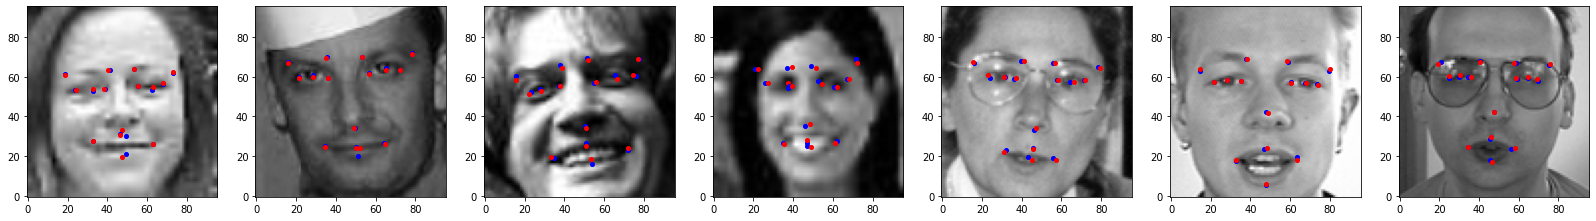

Note: Predicted points are red, and true labels are blue.


In [12]:
## Evaluate Best Model on Semi-Supervised Test Data.
print("Best Model Evalutation on Semi-Supervised Test Data.")

# Get scores.
test_loss, test_mae, test_acc, test_rmse = best_cnn_loaded.evaluate(sup_test_data,
                                      sup_test_labels,
                                      verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Dev Data: %.3f"% (test_mae))
print("Accuracy on Semi-Supervised Dev Data: %.3f"% (test_acc))
print("Root Mean Squared Error on Semi-Supervised Dev Data: %.3f"% (test_rmse))

# Generate & plot predictions.
test_predictions = best_cnn_loaded.predict(sup_test_data)
plot_predictions(sup_test_data, sup_test_labels, test_predictions)

Best Model Evalutation on Semi-Supervised Dev Data.
4/4 - 1s - loss: 1.3482 - mae: 0.7743 - accuracy: 0.8000 - root_mean_squared_error: 1.1611 - 514ms/epoch - 129ms/step

Mean Absolute Error on Semi-Supervised Dev Data: 0.774
Accuracy on Semi-Supervised Dev Data: 0.800
Root Mean Squared Error on Semi-Supervised Dev Data: 1.161


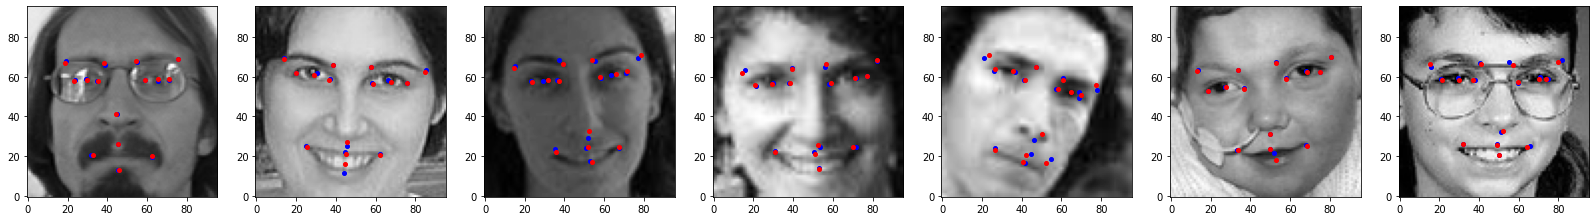

Note: Predicted points are red, and true labels are blue.


In [13]:
## Evaluate BestModel on Semi-Supervised Dev Data.
print("Best Model Evalutation on Semi-Supervised Dev Data.")

# Get scores.
dev_loss, dev_mae, dev_acc, dev_rmse = best_cnn_loaded.evaluate(sup_dev_data,
                                      sup_dev_labels,
                                      verbose=2)
# Print scores.
print("\nMean Absolute Error on Semi-Supervised Dev Data: %.3f"% (dev_mae))
print("Accuracy on Semi-Supervised Dev Data: %.3f"% (dev_acc))
print("Root Mean Squared Error on Semi-Supervised Dev Data: %.3f"% (dev_rmse))

# Generate & plot predictions.
dev_predictions = best_cnn_loaded.predict(sup_dev_data)
plot_predictions(sup_dev_data, sup_dev_labels, dev_predictions)

#### Evaluate on Perfect Evaluation Data to verify

Best Model Evalutation on Perfect Test and Dev Data.
12/12 - 1s - loss: 0.3213 - mae: 0.3370 - accuracy: 0.9633 - root_mean_squared_error: 0.5669 - 1s/epoch - 90ms/step

Mean Absolute Error on Perfect Evaluation Data: 0.337
Accuracy on Perfect Evaluation Data: 0.963
Root Mean Squared Error on Perfect Evaluation Data: 0.567


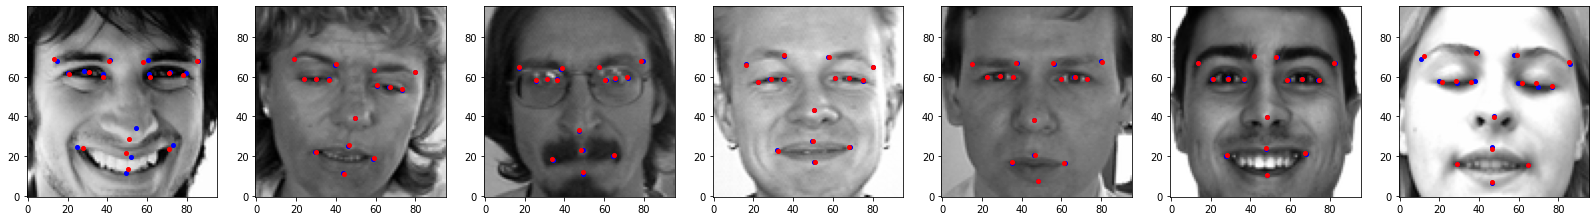

Note: Predicted points are red, and true labels are blue.


In [14]:
## Evaluate Best Model on Perfect Test and Dev Data.
print("Best Model Evalutation on Perfect Test and Dev Data.")

# Get scores.
perf_loss, perf_mae, perf_acc, perf_rmse = best_cnn_loaded.evaluate(
    perf_eval_data, perf_eval_labels, verbose=2)

# Print scores.
print("\nMean Absolute Error on Perfect Evaluation Data: %.3f"% (perf_mae))
print("Accuracy on Perfect Evaluation Data: %.3f"% (perf_acc))
print("Root Mean Squared Error on Perfect Evaluation Data: %.3f"% (perf_rmse))

# Generate & plot predictions.
perf_eval_predictions = best_cnn_loaded.predict(perf_eval_data)
plot_predictions(perf_eval_data, perf_eval_labels, perf_eval_predictions)

### Generate Final Predictions

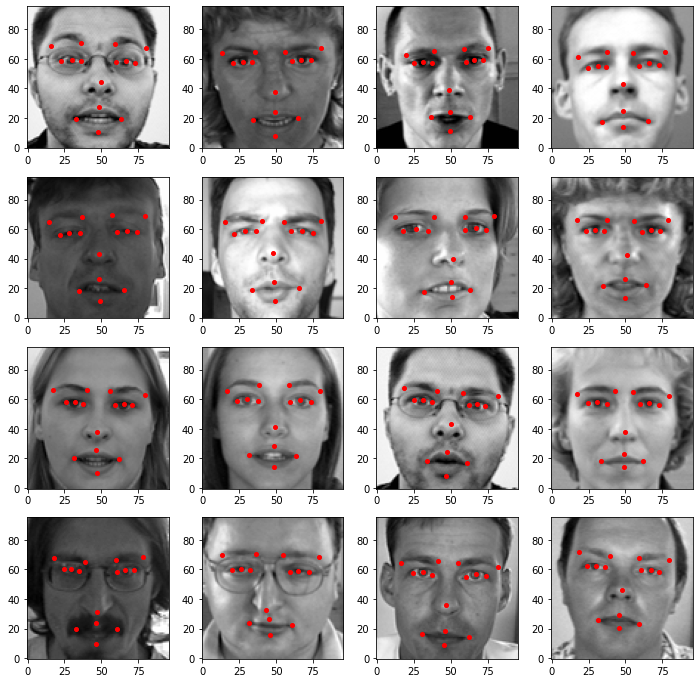

Note: Predicted points are red, and true labels are blue.


In [15]:
# Generate & plot predictions for Final Test Data.

# Generate predictions.
final_predictions = best_cnn_loaded.predict(X_test_final)

# Create new figure.
fig = plt.figure(figsize=(12,12))

# Plot images and true & predicted keypoints.
for i in range(16):
  plt.subplot(4,4,i+1)
  get_image_and_dots(i, X_test_final, 
                     predictions_ar=final_predictions)
plt.show()
print("Note: Predicted points are red, and true labels are blue.")

#### Save Final Predictions

In [44]:
# Specify saved model path
model_name_str = "model_14-1"

base_path_submission = './drive/MyDrive/w207_facial_detection/Kaggle_Submission_Models/'
submission_csv_name = 'submission_' + model_name_str + ".csv"
sub_path = base_path_submission + submission_csv_name

In [45]:
def save_submission_file(save_path:str, final_predictions):
  """
  Save predictions on X_test (final_predictions) 
  using Kaggle's submission format at the specified save_path.
  """

  # load look up id data
  lookid_dir = './drive/MyDrive/w207_facial_detection/Kaggle_Submission_Models/IdLookupTable.csv'
  lookid_data = pd.read_csv(lookid_dir)

  # extract from lookup ID 
  lookid_list = list(lookid_data['FeatureName'])
  imageID = list(lookid_data['ImageId']-1)
  pre_list = list(final_predictions) # final predictions

  rowid = lookid_data['RowId']
  rowid=list(rowid) # row id's for final submission

  # feature indicies for submission
  feature = []
  for f in list(lookid_data['FeatureName']):
      feature.append(lookid_list.index(f))

  # save predictions
  preded = []
  for x,y in zip(imageID,feature):
      preded.append(pre_list[x][y])

  rowid = pd.Series(rowid,name = 'RowId')
  loc = pd.Series(preded,name = 'Location')

  submission = pd.concat([rowid,loc],axis = 1)

  submission.to_csv(sub_path, index = False) # save csv

  print(f"Saved Kaggle submission file to: \n{save_path}\n")

In [46]:
# Model 14.1 submission
save_submission_file(sub_path, final_predictions)

Saved Kaggle submission file to: 
./drive/MyDrive/w207_facial_detection/Kaggle_Submission_Models/submission_model_14-1.csv

